<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#실습목표" data-toc-modified-id="실습목표-1">실습목표</a></span></li><li><span><a href="#0.-들어가며" data-toc-modified-id="0.-들어가며-2">0. 들어가며</a></span></li><li><span><a href="#1.-Data-PreProcess" data-toc-modified-id="1.-Data-PreProcess-3">1. Data PreProcess</a></span><ul class="toc-item"><li><span><a href="#1.1-Data-Load" data-toc-modified-id="1.1-Data-Load-3.1">1.1 Data Load</a></span></li><li><span><a href="#1.2-Session-Length" data-toc-modified-id="1.2-Session-Length-3.2">1.2 Session Length</a></span></li><li><span><a href="#1.3-Session-Time" data-toc-modified-id="1.3-Session-Time-3.3">1.3 Session Time</a></span></li><li><span><a href="#1.4-Data-Cleansing" data-toc-modified-id="1.4-Data-Cleansing-3.4">1.4 Data Cleansing</a></span></li><li><span><a href="#1.5-Train/-Valid/-Test-split" data-toc-modified-id="1.5-Train/-Valid/-Test-split-3.5">1.5 Train/ Valid/ Test split</a></span></li></ul></li><li><span><a href="#2.-Data-Pipeline" data-toc-modified-id="2.-Data-Pipeline-4">2. Data Pipeline</a></span></li><li><span><a href="#3.-Evaluation-Metric" data-toc-modified-id="3.-Evaluation-Metric-5">3. Evaluation Metric</a></span></li><li><span><a href="#4.-Modeling" data-toc-modified-id="4.-Modeling-6">4. Modeling</a></span></li><li><span><a href="#5.-Inference" data-toc-modified-id="5.-Inference-7">5. Inference</a></span></li><li><span><a href="#6.-다른-데이터셋-활용" data-toc-modified-id="6.-다른-데이터셋-활용-8">6. 다른 데이터셋 활용</a></span></li><li><span><a href="#7.-후속-연구-소개" data-toc-modified-id="7.-후속-연구-소개-9">7. 후속 연구 소개</a></span></li></ul></div>

**노드에서 설명하지 않은 것들** <br>
- tensorflow, [pathlib](https://bit.ly/2FEVbLo), 딥러닝 기본(optimizer, loss), RNN, [iter](https://dojang.io/mod/page/view.php?id=2405) <br>
- 코드 가독성을 위해 data type을 함수에 표시해둔 게 있음. 읽는법 안내가 필요.<br>
- 데이터가 7z 확장자로 압축되어 있음. 다운로드 및 압축푸는 과정은 생략함.<br>
- 논문에서는 loss, sampling 방법들에 대한 연구가 더 있는데 이 노드에서는 생략함.

**참고사항**
- 사람에 따라서 [논문](https://arxiv.org/pdf/1511.06939v4.pdf)을 먼저 읽는 것도 좋아보임. <br>
- [코드출처](https://github.com/paxcema/KerasGRU4Rec). 이 사람도 전처리 부분은 다른 두 사람걸 참조함. <br> 
- 이 코드를 많이 리팩토링 함. 노드에 쓰여있는 코드는 이쪽 [레포](https://github.com/ZiminPark/SeqRecSys)에서 확인할 수 있음.

# 실습목표

> 1. Session의 개념을 익힌다.
> 2. Session Based Recommendation의 문제 정의를 익힌다. (+ Sequential Recommendation)
> 3. Session Based Recommendation Task에서 데이터 전처리를 할 때 고려해야할 요소들을 생각해 본다.
> 4. GRU4Rec 모델을 사용해본다.
> 5. 추천 시스템에서 사용하는 Evaluation Metric을 익힌다.

# 0. 들어가며

- ![aladin](./asset/aladin.png)

- 며칠 전 온라인 서점 ['알라딘'](https://www.aladin.co.kr/home/welcome.aspx)에 들어가 책을 구경하고 있었습니다. 개인정보를 남기고 싶지 않아 시크릿모드를 열고 로그인을 하지 않은 상태로 돌아다녔지요. 그런데 웬걸 제가 클릭한 책들이 *오늘 본 상품*에 기록되고 있었고 책 상세페이지에 다른 책들을 추천하고 있었습니다.

- ![amazon](./asset/amazon.png)

- [아마존](https://www.amazon.com/) 역시 마찬가지입니다. 시크릿모드를 켜놓고 캠을 사기위해 이것저것 서핑하고 보니 탐색 내역과 이를 바탕으로 한 추천을 해주고 있습니다.

- 인터넷에서 물건 많이 사시나요? 오늘은 전자상거래 플랫폼에서 많이 사용하고 있는 Session-Based Recommendation을 알아보겠습니다.
- Session-Based Recommendation은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말합니다.
- Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하고 서버 쪽에 저장됩니다.
- 유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받습니다.
- 이번 자료에서는 세션을 유저의 행동 시퀀스 데이터와 같은 의미로 사용하겠습니다. 자세한 내용은 [쿠키, 세션, 캐시가 뭔가요?](https://www.youtube.com/watch?v=OpoVuwxGRDI&ab_channel=%EC%96%84%ED%8C%8D%ED%95%9C%EC%BD%94%EB%94%A9%EC%82%AC%EC%A0%84)를 참고해주세요.

- 추천 시스템을 주로 다루는 학회 RecSys에서는 매년 추천을 주제로 대회를 엽니다. 15년도에는 [YOOCHOOSE](https://www.yoochoose.com/)라는 추천 엔진 솔루션 회사에서 [E-Commerce 데이터](https://2015.recsyschallenge.com/challenge.html)를 공개했습니다. 오늘은 이 데이터를 활용하겠습니다.

- [quiz] 노드에 시작하기 앞서 데이터를 살펴보고 알고 싶은 정보를 생각해봅시다.

>The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session
is encapsulating the click events that the user performed in the session.
For some of the sessions, there are also buy events; means that the session ended
with the user bought something from the web shop. The data was collected during several
months in the year of 2014, reflecting the clicks and purchases performed by the users
of an on-line retailer in Europe.  **To protect end users privacy, as well as the retailer,
all numbers have been modified.** Do not try to reveal the identity of the retailer.

- 데이터 설명을 읽어보면 몇 가지 주목할만한 점이 있습니다. 
    1. 유저에 대한 정보를 전혀 알 수 없습니다. 성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등
    2. 아이템에 대한 정보도 전혀 알 수 없습니다. 실제로 어떤 물건인지, 사진이나 설명, 가격

- 이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 Sequential Recommendation 이라고 구별해서 부르기도 합니다.
- 유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware 라는 키워드로 활발히 연구되고 있습니다.

- 또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다고 합니다.(저도 E-Commerce 회사에 다녀본 적은 없습니다.)
    1. 비로그인 상태로 탐색하는 유저가 많습니다.
    2. 로그인 상태로 탐색한다고 할지라도 접속할 때 마다 탐색하는 의도가 뚜렷하게 다릅니다.<br>
    즉, 마우스를 사야겠다고 마음먹고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않습니다.

# 1. Data PreProcess

- 데이터를 살펴보고 주요 통계치들을 살펴봅시다.
- 이번 자료에서는 Click 데이터에 있는 Session Id, TimeStamp, ItemId 칼럼만 사용하겠습니다.

## 1.1 Data Load

In [40]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [48]:
# pathlib 라이브러리에 대한 내용은 https://bit.ly/2FEVbLo 이쪽을 참고해주세요.
data_path = Path('/Users/zimin/Downloads/archive/')  # 'D:\\data\\yoochoose-data\\'
train_path = data_path / 'yoochoose-clicks.dat'

In [51]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
data = load_data(train_path, None)
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
33003939,11299809,2014-09-25 09:33:22.412000+00:00,214819412
33003940,11299809,2014-09-25 09:43:52.821000+00:00,214830939
33003941,11299811,2014-09-24 19:02:09.741000+00:00,214854855
33003942,11299811,2014-09-24 19:02:11.894000+00:00,214854838


- 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.

In [7]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

- 세션의 숫자가 900만개, 아이템 숫자는 5만개가 됩니다.
- 이 수치가 유저의 수가 900만명이라는 것은 아닙니다. 같은 유저가 여러 개의 세션을 만들수도 있기 때문입니다.

## 1.2 Session Length

- 각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.

In [9]:
session_length = data.groupby('SessionId').size()

In [11]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [12]:
session_length.min(), session_length.max()

(1, 200)

In [14]:
session_length.quantile(0.999)

41.0

- 각 세션의 길이는 보통 2~3 정도입니다. 온라인에서 쇼핑할 때를 생각해보면 이 수치가 그럴듯하게 느껴집니다.
- 99.9% 세션은 길이가 41이하입니다. 
- 길이가 200인 세션은 뭔가 이상합니다. 하나를 잡고 살펴봅시다.

In [34]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


- 매우 짧은 간격으로 지속적으로 클릭을 1시간 30분 가량 지속하고 있습니다.
- 유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다.<br>
    e.g.) 음악 데이터의 경우 어떤 사람은 하루종일 랜덤재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?<br>
    e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?
- 너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해보세요.

- 세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다.

In [35]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

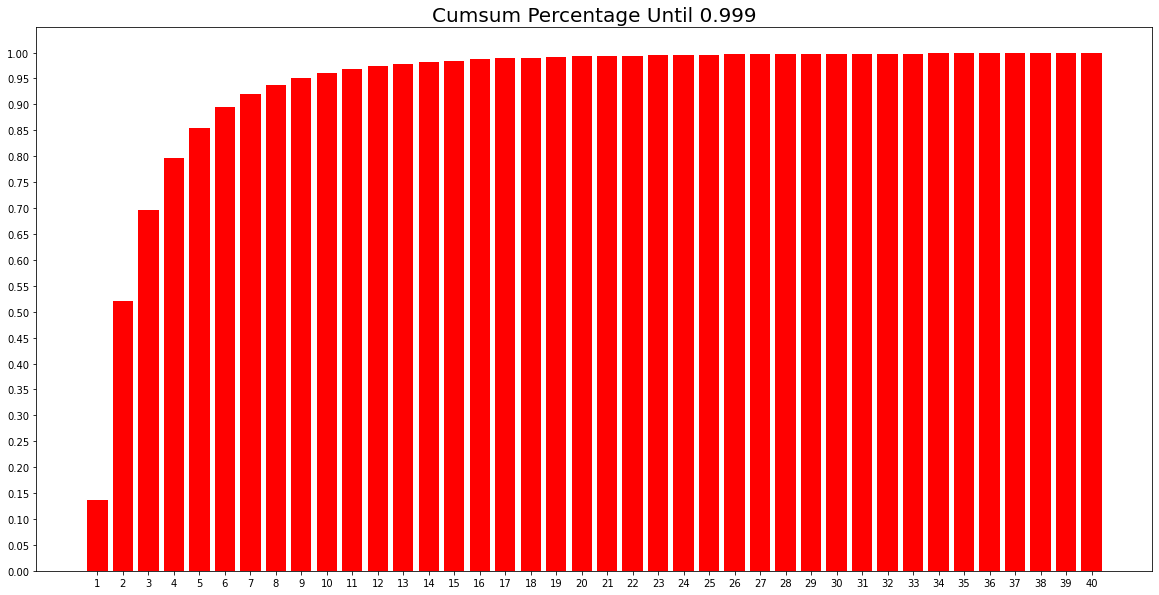

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

[quiz] 이 데이터에 Matrix Factorization을 사용하면 어떨까요? <br>
- User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다.

## 1.3 Session Time

- 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 10월에는 아이폰12를 구매하려는 사람이 많을 것입니다.
- 5개월 전에는 어땠을까요? 아이폰 SE2를 구매하려는 사람이 많았을 것입니다.
- 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변합니다.
- 이런 이유 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.
- [quiz] 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있습니다. 데이터 생성 날짜 말고 또 어떤 요소가 있을까요?
    - 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

In [37]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


- 데이터 설명대로 6개월치 데이터가 있습니다.
- 저는 1달치 데이터만 사용하려고 합니다. 6개월치 데이터를 사용하면 성능이 더 좋아질까요?

In [39]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않습니다.
- 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용합니다.

In [41]:
month_ago = latest - dt.timedelta(30)
data = data[data['Time'] > month_ago]

In [42]:
data

,SessionId,Time,ItemId
26566438,9293604,2014-09-01 18:07:58.937000+00:00,214839911
26566444,9293607,2014-08-31 19:01:38.317000+00:00,214853420
26566445,9293607,2014-08-31 19:01:46.778000+00:00,214850949
26566446,9293601,2014-08-31 09:00:52.538000+00:00,214853317
26566447,9293601,2014-08-31 09:04:07.818000+00:00,214821373
...,...,...,...
33003939,11299809,2014-09-25 09:33:22.412000+00:00,214819412
33003940,11299809,2014-09-25 09:43:52.821000+00:00,214830939
33003941,11299811,2014-09-24 19:02:09.741000+00:00,214854855
33003942,11299811,2014-09-24 19:02:11.894000+00:00,214854838


## 1.4 Data Cleansing

- 1.2에서 살펴보니 길이가 1인 세션도 꽤 있습니다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해줍니다.
- 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있습니다. 이 역시 제거해줍니다.

In [45]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [46]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26566444,9293607,2014-08-31 19:01:38.317000+00:00,214853420
26566445,9293607,2014-08-31 19:01:46.778000+00:00,214850949
26566446,9293601,2014-08-31 09:00:52.538000+00:00,214853317
26566447,9293601,2014-08-31 09:04:07.818000+00:00,214821373
26566448,9293601,2014-08-31 09:06:42.696000+00:00,214701787
...,...,...,...
33003939,11299809,2014-09-25 09:33:22.412000+00:00,214819412
33003940,11299809,2014-09-25 09:43:52.821000+00:00,214830939
33003941,11299811,2014-09-24 19:02:09.741000+00:00,214854855
33003942,11299811,2014-09-24 19:02:11.894000+00:00,214854838


## 1.5 Train/ Valid/ Test split

- 모델 평가를 위해 Valid Set과 Test Set을 만들어 봅니다.
- [quiz] 이전에는 어떤식으로 Train과 Valid를 나눴었나요?

- 대회에서 Test Set을 제공해주고 있습니다. 한 번 살펴봅시다.

In [61]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

- Test 셋을 살펴보니 Training 셋과 기간이 겹칩니다.
- 하지만 1.3에서 말했듯이 추천 시스템은 `지금` 잘 예측하는 게 중요합니다. 
- 1달 전에 성능이 좋은 모델을 지금 쓰면 사용자들의 소비 패턴이 달라졌기 때문입니다.
- 이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 합니다. <br>
  이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일전부터 1일전 까지를 valid set으로 나누겠습니다.
 
![split](./asset/split.png)

In [62]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [63]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [64]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [65]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



- 이제 데이터 준비를 마쳤습니다! 데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가겠습니다.

In [66]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. Data Pipeline

- Session-Parrarel Mini-Batch 를 왜 썼는지 -> 사실 요즘 논문에서는 거의 안쓴다.대신 데이터 특징을 살린 모델링.

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data, session_key='SessionId', item_key='ItemId', time_key='Time'):
        self.df = data
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.idx2id = self.get_vocab()
        self.df['item_idx'] = self.df['ItemId'].map(self.idx2id.get)

        self.df.sort_values([session_key, time_key], inplace=True)
        self.click_offsets = self.get_click_offsets()
        self.session_idx_arr = np.arange(self.df[self.session_key].nunique())  # indexing to SessionId

    def get_vocab(self):
        return {index: item_id for item_id, index in enumerate(self.df['ItemId'].unique())}

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df[self.session_key].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby(self.session_key).size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [26]:
tr_dataset.session_idx_arr

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

In [27]:
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,89
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,298
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,1375
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,3716
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,97
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,98
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,2327
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,2327


In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = first_iters[-1]
        start = self.dataset.click_offsets[self.dataset.session_idx_arr[first_iters]]
        end = self.dataset.click_offsets[self.dataset.session_idx_arr[first_iters] + 1]
        mask = []
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start, end, min_len, last_session, finished):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.session_idx_arr[-1]:
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx_arr[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx_arr[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

[iter 설명](https://dojang.io/mod/page/view.php?id=2405)

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = tr_data_loader.__iter__()

tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,89
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,298
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,1375
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,3716
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,97
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,98
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,2327
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,2327


- 아래 셀을 반복 실행하면 next가 계속 뱉어냄, input, output, mask를 감잡아 봅시다

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0 1375   97 2327]
Label Item Idx are :       [  89 3716   98 2327]
Previous Masked Input Idx are []


# 3. Evaluation Metric

- 평가 설명 (mAP, NDCG도 있다)

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# 4. Modeling

- 모델 구조가 간단하므로 Funtional 모델

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

- quiz 구조 바꿔보기, embedding 추가, layer 더 쌓기 등등

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr))
    model.summary()
    return model

In [34]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [35]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


In [36]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for i, (feat, target, mask) in enumerate(tr_loader):
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            tr_loss = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=tr_loss)

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')
    hidden_states = gru_layer.states[0].numpy()
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
train_model(model, args)

Train:  15%|█▌        | 290/1895 [02:42<14:57,  1.79it/s, train_loss=7.84]


KeyboardInterrupt: 

# 5. Inference

quiz. test 셋 평가코드 직접 만들기

In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [39]:
test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [02:04<00:28,  5.66s/it]

	 - Recall@20: 0.038042
	 - MRR@20: 0.011738



# 6. 다른 데이터셋 활용

- 아마존 리뷰 데이터
- 스팀 리뷰 데이터
- Movielens

# 7. 후속 연구 소개

- 자연어 처리 기반 모델
- GNN 기반 모델
- RL 기반 모델
- CNN 기반 모델
- Knowledge Graph 기반 모델